In [1]:
import cudaq
import numpy as np

# 1. 시뮬레이션 타겟 설정 (State Vector 방식 + GPU 가속)
cudaq.set_target("nvidia")

# 2. 파라미터화된 양자 커널 정의
qubit_count = 20

@cudaq.kernel
def circuit(params: list[float]):
    # 큐비트 할당
    qubits = cudaq.qvector(qubit_count)
    
    # 1개 레이어: 각 큐비트에 파라미터화된 RY 회전 게이트 적용
    for i in range(qubit_count):
        cudaq.ry(params[i], qubits[i])
    
    # 얽힘을 위한 간단한 CNOT 체인 (선택 사항)
    for i in range(qubit_count - 1):
        cudaq.cx(qubits[i], qubits[i+1])

# 3. 관측자(Observable) 정의 
# 여기서는 모든 큐비트의 Z축 측정 합 (Total Magnetization)을 최소화하는 것을 목표로 합니다.
hamiltonian = cudaq.spin.z(0)
for i in range(1, qubit_count):
    hamiltonian += cudaq.spin.z(i)

# 4. 초기 파라미터 설정 (100개까지 확장 가능하지만, 현재 예제는 20개)
params = np.random.uniform(-np.pi, np.pi, qubit_count)

# 5. 기댓값 및 기울기 계산
# observe().expectation()은 기댓값을, cudaq.gradient()는 Adjoint 방식으로 기울기를 구합니다.
def cost_function(current_params):
    expectation_value = cudaq.observe(circuit, hamiltonian, current_params).expectation()
    return expectation_value

# Adjoint Differentiation을 이용한 기울기 추출
# 파라미터 개수가 많아도 Parameter-shift보다 훨씬 빠르게 계산됩니다.
gradients = cudaq.gradient(circuit, hamiltonian, params)

print(f"Current Expectation Value: {cost_function(params):.6f}")
print(f"Gradients (first 5): {gradients[:5]}")

# 6. 간단한 경사 하강법(Gradient Descent) 적용 예시
learning_rate = 0.1
for step in range(10):
    grads = cudaq.gradient(circuit, hamiltonian, params)
    params -= learning_rate * grads
    if step % 2 == 0:
        print(f"Step {step}: Cost = {cost_function(params):.6f}")

print(f"Final Optimized Cost: {cost_function(params):.6f}")

AttributeError: module 'cudaq' has no attribute 'gradient'

In [2]:
import cudaq
import numpy as np

# 1. 타겟 설정
cudaq.set_target("nvidia")

qubit_count = 20

@cudaq.kernel
def circuit(params: list[float]):
    qubits = cudaq.qvector(qubit_count)
    for i in range(qubit_count):
        ry(params[i], qubits[i])
    for i in range(qubit_count - 1):
        x.ctrl(qubits[i], qubits[i+1])

# 2. Hamiltonian 정의
hamiltonian = cudaq.spin.z(0)
for i in range(1, qubit_count):
    hamiltonian += cudaq.spin.z(i)

# 미분 엔진 생성
gradient_engine = cudaq.gradients.ParameterShift()

# 1. 'function' 인자로 들어갈 callable 정의
# 파라미터 리스트를 받아 기댓값(float)을 반환해야 함
def loss_func(p):
    return cudaq.observe(circuit, hamiltonian, p).expectation()

# 초기 파라미터 (list 형식을 선호할 수 있으므로 변환)
params = np.random.uniform(-np.pi, np.pi, qubit_count).tolist()

learning_rate = 0.1
for step in range(10):
    # 2. funcAtX 계산 (현재 지점의 기댓값)
    current_expect = loss_func(params)
    
    # 3. compute 호출: (parameter_vector, function, funcAtX)
    # 에러 메시지의 서명에 맞춰 인자를 전달합니다.
    grads = gradient_engine.compute(params, loss_func, current_expect)
    
    # 파라미터 업데이트
    params = (np.array(params) - learning_rate * np.array(grads)).tolist()
    
    if step % 2 == 0:
        print(f"Step {step}: Cost = {current_expect:.6f}")

print(f"Final Optimized Cost: {loss_func(params):.6f}")

Step 0: Cost = -1.740672
Step 2: Cost = -1.942469
Step 4: Cost = -2.112394
Step 6: Cost = -2.343799
Step 8: Cost = -2.742951
Final Optimized Cost: -3.423657


In [1]:
import cudaq
import numpy as np

cudaq.set_target("nvidia")
qubit_count = 20

@cudaq.kernel
def circuit(params: list[float]):
    qubits = cudaq.qvector(qubit_count)
    for i in range(qubit_count):
        ry(params[i], qubits[i])
    for i in range(qubit_count - 1):
        x.ctrl(qubits[i], qubits[i+1])

hamiltonian = cudaq.spin.z(0)
for i in range(1, qubit_count):
    hamiltonian += cudaq.spin.z(i)

# 미분 엔진 생성
gradient_engine = cudaq.gradients.ParameterShift()

# 1. 'function' 인자로 들어갈 callable 정의
# 파라미터 리스트를 받아 기댓값(float)을 반환해야 함
def loss_func(p):
    return cudaq.observe(circuit, hamiltonian, p).expectation()

# 초기 파라미터 (list 형식을 선호할 수 있으므로 변환)
params = np.random.uniform(-np.pi, np.pi, qubit_count).tolist()
print(params)
learning_rate = 0.1
for step in range(10):
    # 2. funcAtX 계산 (현재 지점의 기댓값)
    current_expect = loss_func(params)
    
    # 3. compute 호출: (parameter_vector, function, funcAtX)
    # 에러 메시지의 서명에 맞춰 인자를 전달합니다.
    grads = gradient_engine.compute(params, loss_func, current_expect)
    
    # 파라미터 업데이트
    params = (np.array(params) - learning_rate * np.array(grads)).tolist()
    
    if step % 2 == 0:
        print(f"Step {step}: Cost = {current_expect:.6f}")
print(params)
print(f"Final Optimized Cost: {loss_func(params):.6f}")

[-1.8692185461439579, 2.035350732655954, -1.3899194438619689, -0.07471885770553888, -2.6916414295746596, -1.905307896869438, -1.398451930839478, 0.03265969298056515, 2.2150740091467807, 0.025502851351576705, -1.8084498073384458, -1.3237087904260014, -1.5600663006838422, 1.9983200935342476, 3.0841819913948054, -1.1796351502170752, -2.5674490641724916, 2.8727235520705454, -1.5955277207608647, -0.7570626681985391]
Step 0: Cost = -0.128085
Step 2: Cost = -0.202303
Step 4: Cost = -0.308173
Step 6: Cost = -0.449203
Step 8: Cost = -0.623854
[-2.448108202295145, 1.4965591924027675, -1.5438802520090578, -0.07511868262220203, -2.6949229849813605, -1.8932338841927179, -1.4018523667820582, 0.03265919487987948, 2.2158947283769277, 0.025496336536467497, -1.8080115023016885, -1.3237922565822007, -1.5600901492065116, 1.9983200215988626, 3.08418198510825, -1.179635229106405, -2.5674490799550447, 2.8727235449277058, -1.5955277708467266, -0.7570626759905824]
Final Optimized Cost: -0.828255


In [ ]:
import cudaq
import numpy as np

cudaq.set_target("nvidia")
qubit_count = 16
layer_count = 3  # 레이어 반복 횟수

@cudaq.kernel
def circuit(params: list[float]):
    qubits = cudaq.qvector(qubit_count)
    
    # 레이어 반복 루프
    for layer in range(layer_count):    
        # 현재 레이어의 파라미터 시작 인덱스 계산
        offset = layer * qubit_count
        
        # 1. Rotation Layer
        for i in range(qubit_count):
            ry(params[offset + i], qubits[i])
            
        # 2. Entanglement Layer (CNOT Chain)
        for i in range(qubit_count - 1):
            x.ctrl(qubits[i], qubits[i+1])

# 각 큐비트별 Z 관측자 리스트
observables = [cudaq.spin.z(i) for i in range(qubit_count)]
target_values = np.full(qubit_count, -1.0)

gradient_engine = cudaq.gradients.ParameterShift()

def loss_func(p):
    current_expectations = []
    for obs in observables:
        res = cudaq.observe(circuit, obs, p).expectation()
        current_expectations.append(res)
    
    current_expectations = np.array(current_expectations)
    mse = np.mean((current_expectations - target_values)**2)
    return float(mse)

# 초기 파라미터 개수: 20 * 3 = 60개
total_param_count = qubit_count * layer_count
params = np.random.uniform(-np.pi, np.pi, total_param_count).tolist()

learning_rate = 0.2
print(f"Initial Params Count: {len(params)}")

for step in range(20):
    current_mse = loss_func(params)
    grads = gradient_engine.compute(params, loss_func, current_mse)
    
    params = (np.array(params) - learning_rate * np.array(grads)).tolist()
    
    if step % 2 == 0:
        print(f"Step {step}: MSE Cost = {current_mse:.6f}")

print(f"Final Optimized MSE: {loss_func(params):.6f}")

Initial Params Count: 48
Step 0: MSE Cost = 1.076477
Step 2: MSE Cost = 1.061244
Step 4: MSE Cost = 1.046238
Step 6: MSE Cost = 1.031443
Step 8: MSE Cost = 1.016859
Step 10: MSE Cost = 1.002506
Step 12: MSE Cost = 0.988427
Step 14: MSE Cost = 0.974686
Step 16: MSE Cost = 0.961359
Step 18: MSE Cost = 0.948529
Final Optimized MSE: 0.936273


## GAN

### Gen만 학습

In [ ]:
import cudaq
import torch
import torch.nn as nn
import numpy as np

cudaq.set_target("nvidia")

# 1. 환경 설정
qubit_count = 16
layer_count = 3
total_param_count = qubit_count * layer_count

# 2. CUDA-Q 양자 커널 (Generator)
@cudaq.kernel
def kernel_g(params: list[float]):
    qubits = cudaq.qvector(qubit_count)
    for layer in range(layer_count):
        offset = layer * qubit_count
        for i in range(qubit_count):
            ry(params[offset + i], qubits[i])
        for i in range(qubit_count - 1):
            x.ctrl(qubits[i], qubits[i+1])

# 3. 고전 Discriminator 정의 (PyTorch)
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 4. 초기화
discriminator = Discriminator(qubit_count)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.01)

# Generator 파라미터 (Leaf Tensor로 설정하여 미분 추적)
gen_params = torch.tensor(np.random.uniform(-np.pi, np.pi, total_param_count), 
                          requires_grad=True, dtype=torch.float32)
g_optimizer = torch.optim.Adam([gen_params], lr=0.1)

# 관측자 설정 (각 큐비트의 Z 기댓값 추출)
observables = [cudaq.spin.z(i) for i in range(qubit_count)]
gradient_engine = cudaq.gradients.ParameterShift()

print(gen_params)
# 5. 학습 루프
for step in range(50):
    g_optimizer.zero_grad()
    
    params_list = gen_params.detach().numpy().tolist()
    
    # 각 큐비트의 기댓값을 저장할 리스트
    current_exp_values = [] 
    expectations = []
    
    for obs in observables:
        # 현재 파라미터에서의 기댓값을 미리 계산 (funcAtX로 사용)
        res = cudaq.observe(kernel_g, obs, params_list).expectation()
        current_exp_values.append(res)
        expectations.append(res)
    
    q_output = torch.tensor(expectations, dtype=torch.float32, requires_grad=True)
    
    # Discriminator 평가 및 Loss 계산
    prob_fake = discriminator(q_output)
    g_loss = -torch.log(prob_fake + 1e-8)
    g_loss.backward()
    
    # Quantum Gradient 수동 주입
    with torch.no_grad():
        grad_output = q_output.grad.numpy()
        # 누적 전 초기화 (중요)
        if gen_params.grad is None:
            gen_params.grad = torch.zeros_like(gen_params)
        else:
            gen_params.grad.zero_()

        for i, obs in enumerate(observables):
            # 수정된 부분: 세 번째 인자로 current_exp_values[i]를 전달
            q_grads = gradient_engine.compute(
                params_list, 
                lambda p: cudaq.observe(kernel_g, obs, p).expectation(),
                current_exp_values[i]  # funcAtX 인자 추가
            )
            
            # Chain Rule 적용: dL/d_theta = dL/d_exp * d_exp/d_theta
            gen_params.grad += grad_output[i] * torch.tensor(q_grads, dtype=torch.float32)

    g_optimizer.step()

    if step % 5 == 0:
        print(f"Step {step}: G_Loss = {g_loss.item():.6f}, D_Output = {prob_fake.item():.6f}")

print(gen_params)

### Discri 추가

In [ ]:
real_data = torch.full((qubit_count,), -1.0, dtype=torch.float32)

for step in range(100):
    
    # ==========================================
    # 1. Discriminator (D) 학습 단계
    # ==========================================
    d_optimizer.zero_grad()
    
    # 진짜 데이터에 대한 판단 (1.0에 가까워야 함)
    prob_real = discriminator(real_data)
    d_loss_real = -torch.log(prob_real + 1e-8)
    
    # 가짜 데이터(G의 출력) 생성
    params_list = gen_params.detach().numpy().tolist()
    expectations = []
    for obs in observables:
        res = cudaq.observe(kernel_g, obs, params_list).expectation()
        expectations.append(res)
    q_output_for_d = torch.tensor(expectations, dtype=torch.float32)
    
    # 가짜 데이터에 대한 판단 (0.0에 가까워야 함)
    prob_fake_d = discriminator(q_output_for_d.detach()) # G의 미분은 끊고 D만 학습
    d_loss_fake = -torch.log(1.0 - prob_fake_d + 1e-8)
    
    # D의 전체 손실 및 업데이트
    d_loss = (d_loss_real + d_loss_fake) / 2
    d_loss.backward()
    d_optimizer.step()
    
    # ==========================================
    # 2. Generator (G) 학습 단계
    # ==========================================
    g_optimizer.zero_grad()
    
    # G가 만든 데이터를 다시 D에게 입력
    # (이미 계산한 expectations를 사용하되, 이번엔 grad를 추적함)
    q_output_for_g = torch.tensor(expectations, dtype=torch.float32, requires_grad=True)
    prob_fake_g = discriminator(q_output_for_g)
    
    # G의 Loss: D를 속여서 1.0을 얻는 것이 목표
    g_loss = -torch.log(prob_fake_g + 1e-8)
    g_loss.backward()
    
    # CUDA-Q Parameter-Shift로 G 미분 주입
    with torch.no_grad():
        grad_output = q_output_for_g.grad.numpy()
        if gen_params.grad is None:
            gen_params.grad = torch.zeros_like(gen_params)
        else:
            gen_params.grad.zero_()

        for i, obs in enumerate(observables):
            q_grads = gradient_engine.compute(
                params_list, 
                lambda p: cudaq.observe(kernel_g, obs, p).expectation(),
                expectations[i]
            )
            gen_params.grad += grad_output[i] * torch.tensor(q_grads, dtype=torch.float32)

    g_optimizer.step()

    # 결과 출력
    if step % 10 == 0:
        print(f"Step {step} | D_Loss: {d_loss.item():.4f} | G_Loss: {g_loss.item():.4f} | D(Real): {prob_real.item():.4f} | D(Fake): {prob_fake_g.item():.4f}")

Step 0 | D_Loss: 0.9221 | G_Loss: 0.5462 | D(Real): 0.5198 | D(Fake): 0.5792
Step 10 | D_Loss: 0.3541 | G_Loss: 0.7658 | D(Real): 0.9509 | D(Fake): 0.4650
Step 20 | D_Loss: 0.5697 | G_Loss: 0.4828 | D(Real): 0.9979 | D(Fake): 0.6171
Step 30 | D_Loss: 0.1044 | G_Loss: 2.8654 | D(Real): 0.8850 | D(Fake): 0.0570
Step 40 | D_Loss: 0.0749 | G_Loss: 2.1435 | D(Real): 0.9923 | D(Fake): 0.1172
Step 50 | D_Loss: 0.7502 | G_Loss: 0.3762 | D(Real): 0.9992 | D(Fake): 0.6865
Step 60 | D_Loss: 0.1744 | G_Loss: 3.9831 | D(Real): 0.7288 | D(Fake): 0.0186
Step 70 | D_Loss: 0.0419 | G_Loss: 2.6753 | D(Real): 0.9872 | D(Fake): 0.0689
Step 80 | D_Loss: 0.2099 | G_Loss: 1.4633 | D(Real): 0.9924 | D(Fake): 0.2315
Step 90 | D_Loss: 0.1166 | G_Loss: 2.2292 | D(Real): 0.9087 | D(Fake): 0.1076


### 배치화?

In [17]:
# 파라미터 및 데이터 설정
batch_size = 8
real_data = torch.full((batch_size, qubit_count), -1.0, dtype=torch.float32)

print(f"Starting Training with Batch Size: {batch_size}")

for step in range(100):
    # ==========================================
    # 1. Discriminator (D) 학습 단계
    # ==========================================
    d_optimizer.zero_grad()
    
    # [Real Data] 판별
    prob_real = discriminator(real_data)
    d_loss_real = -torch.log(prob_real + 1e-8).mean()
    
    # [Fake Data] 생성 (양자 회로 실행)
    params_np = gen_params.detach().numpy()
    # 현재 G의 파라미터를 리스트로 변환 (배치 내 모든 샘플이 현재는 동일한 G를 공유)
    params_list = params_np.tolist()
    
    expectations = []
    for obs in observables:
        # 단일 파라미터 셋에 대한 기댓값 계산
        res = cudaq.observe(kernel_g, obs, params_list).expectation()
        expectations.append(res)
    
    # G의 출력을 배치 형태로 복제하여 D의 입력으로 준비 [batch_size, qubit_count]
    q_output_vec = torch.tensor(expectations, dtype=torch.float32)
    q_output_batch = q_output_vec.repeat(batch_size, 1)
    
    # [Fake Data] 판별 (D만 학습하기 위해 detach 사용)
    prob_fake_d = discriminator(q_output_batch.detach())
    d_loss_fake = -torch.log(1.0 - prob_fake_d + 1e-8).mean()
    
    # D 업데이트
    d_loss = (d_loss_real + d_loss_fake) / 2
    d_loss.backward()
    d_optimizer.step()
    
    # ==========================================
    # 2. Generator (G) 학습 단계
    # ==========================================
    g_optimizer.zero_grad()
    
    # G의 미분 경로를 만들기 위해 다시 입력 (requires_grad=True)
    q_output_for_g = q_output_vec.repeat(batch_size, 1)
    q_output_for_g.requires_grad = True
    
    prob_fake_g = discriminator(q_output_for_g)
    
    # G Loss: D가 1(Real)이라고 판단하게 만드는 것이 목표
    g_loss = -torch.log(prob_fake_g + 1e-8).mean()
    g_loss.backward()
    
    # 양자 그래디언트 수동 주입 (Parameter-Shift Rule)
    with torch.no_grad():
        # D로부터 전달된 q_output에 대한 기울기 [batch_size, qubit_count]
        # 배치 평균 기울기를 구함
        grad_from_d = q_output_for_g.grad.mean(dim=0).numpy() 
        
        if gen_params.grad is None:
            gen_params.grad = torch.zeros_like(gen_params)
        else:
            gen_params.grad.zero_()

        # 각 관측자(큐비트)별로 파라미터에 대한 기울기 계산
        for i, obs in enumerate(observables):
            # d(Expectation) / d(Params)
            q_grads = gradient_engine.compute(
                params_list, 
                lambda p: cudaq.observe(kernel_g, obs, p).expectation(),
                expectations[i]
            )
            
            # Chain Rule: dL/dp = dL/de * de/dp
            # 각 큐비트 i에서 온 기울기를 최종 파라미터 grad에 누적
            gen_params.grad += grad_from_d[i] * torch.tensor(q_grads, dtype=torch.float32)

    g_optimizer.step()

    # 결과 출력
    if step % 5 == 0:
        print(f"Step {step:3d} | D_Loss: {d_loss.item():.4f} | G_Loss: {g_loss.item():.4f} | "
              f"D(Real): {prob_real.mean().item():.3f} | D(Fake): {prob_fake_g.mean().item():.3f}")

Starting Training with Batch Size: 8
Step   0 | D_Loss: 0.6563 | G_Loss: 0.7346 | D(Real): 0.525 | D(Fake): 0.480
Step   5 | D_Loss: 0.3812 | G_Loss: 0.7050 | D(Real): 0.939 | D(Fake): 0.494
Step  10 | D_Loss: 0.5460 | G_Loss: 0.4830 | D(Real): 0.985 | D(Fake): 0.617
Step  15 | D_Loss: 0.4937 | G_Loss: 0.7801 | D(Real): 0.894 | D(Fake): 0.458
Step  20 | D_Loss: 0.4752 | G_Loss: 1.5085 | D(Real): 0.504 | D(Fake): 0.221
Step  25 | D_Loss: 0.3421 | G_Loss: 0.9028 | D(Real): 0.845 | D(Fake): 0.405
Step  30 | D_Loss: 0.4266 | G_Loss: 1.0567 | D(Real): 0.801 | D(Fake): 0.348
Step  35 | D_Loss: 0.9466 | G_Loss: 0.4825 | D(Real): 0.454 | D(Fake): 0.617
Step  40 | D_Loss: 0.9599 | G_Loss: 0.4081 | D(Real): 0.595 | D(Fake): 0.665
Step  45 | D_Loss: 0.6136 | G_Loss: 0.7759 | D(Real): 0.701 | D(Fake): 0.460
Step  50 | D_Loss: 0.4568 | G_Loss: 1.0369 | D(Real): 0.807 | D(Fake): 0.355
Step  55 | D_Loss: 0.2107 | G_Loss: 1.8027 | D(Real): 0.906 | D(Fake): 0.165
Step  60 | D_Loss: 0.0721 | G_Loss: 2.7

In [51]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np

# 1. 환경 설정
qubit_count = 18
layer_count = 3
batch_size = 8
device = qml.device("lightning.qubit", wires=qubit_count)

# 2. PennyLane QNode 정의 (Broadcasting & Adjoint 적용)
@qml.qnode(device, diff_method="adjoint", interface="torch")
def quantum_generator(params):
    # params shape: (batch_size, layer_count * qubit_count) 또는 (layer_count * qubit_count,)
    # PennyLane은 첫 번째 차원이 batch임을 자동으로 인식하여 병렬 처리함
    for layer in range(layer_count):
        offset = layer * qubit_count
        for i in range(qubit_count):
            qml.RY(params[..., offset + i], wires=i)
        for i in range(qubit_count - 1):
            qml.CNOT(wires=[i, i+1])
    
    # 각 큐비트의 Z 기댓값을 리턴 (배치 처리됨)
    return [qml.expval(qml.PauliZ(i)) for i in range(qubit_count)]

# 3. Discriminator 정의 (동일)
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 4. 초기화
discriminator = Discriminator(qubit_count)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.01)

# Generator 파라미터 (PennyLane-Torch 인터페이스가 미분을 자동 추적함)
gen_params = torch.nn.Parameter(
    torch.randn(layer_count * qubit_count) * 0.01, requires_grad=True
)
g_optimizer = torch.optim.Adam([gen_params], lr=0.1)

real_data = torch.full((batch_size, qubit_count), -1.0, dtype=torch.float32)

print(f"Starting Training with PennyLane (Batch Size: {batch_size})")

for step in range(100):
    # ==========================================
    # 1. Discriminator (D) 학습 단계
    # ==========================================
    d_optimizer.zero_grad()
    
    # Real Data 판별
    prob_real = discriminator(real_data)
    d_loss_real = -torch.log(prob_real + 1e-8).mean()
    
    # Fake Data 생성 (PennyLane QNode 호출)
    # gen_params를 (batch_size, n_params)로 확장하여 브로드캐스팅 적용
    batched_params = gen_params.unsqueeze(0).expand(batch_size, -1)
    # qml.qnode의 리스트 리턴은 (qubit_count, batch_size) 형식이므로 transpose 필요
    q_output = torch.stack(quantum_generator(batched_params)).t()
    
    # Fake Data 판별 (D만 학습)
    prob_fake_d = discriminator(q_output.detach())
    d_loss_fake = -torch.log(1.0 - prob_fake_d + 1e-8).mean()
    
    d_loss = (d_loss_real + d_loss_fake) / 2
    d_loss.backward()
    d_optimizer.step()
    
    # ==========================================
    # 2. Generator (G) 학습 단계
    # ==========================================
    g_optimizer.zero_grad()
    
    # G는 D가 Real(1)이라고 믿게 만드는 것이 목표
    # Adjoint 미분 덕분에 이 지점에서 바로 backward 가능
    prob_fake_g = discriminator(q_output)
    g_loss = -torch.log(prob_fake_g + 1e-8).mean()
    
    g_loss.backward()
    g_optimizer.step()

    if step % 5 == 0:
        print(f"Step {step:3d} | D_Loss: {d_loss.item():.4f} | G_Loss: {g_loss.item():.4f} | "
              f"D(Real): {prob_real.mean().item():.3f} | D(Fake): {prob_fake_g.mean().item():.3f}")

Starting Training with PennyLane (Batch Size: 8)
Step   0 | D_Loss: 0.6868 | G_Loss: 1.1120 | D(Real): 0.498 | D(Fake): 0.329
Step   5 | D_Loss: 0.2067 | G_Loss: 1.3254 | D(Real): 0.959 | D(Fake): 0.266
Step  10 | D_Loss: 0.2275 | G_Loss: 1.0950 | D(Real): 0.998 | D(Fake): 0.335
Step  15 | D_Loss: 0.1413 | G_Loss: 1.5111 | D(Real): 1.000 | D(Fake): 0.221
Step  20 | D_Loss: 0.4006 | G_Loss: 0.6497 | D(Real): 1.000 | D(Fake): 0.522
Step  25 | D_Loss: 0.8933 | G_Loss: 0.2590 | D(Real): 1.000 | D(Fake): 0.772
Step  30 | D_Loss: 0.5941 | G_Loss: 0.6097 | D(Real): 0.981 | D(Fake): 0.544
Step  35 | D_Loss: 0.7129 | G_Loss: 1.4749 | D(Real): 0.323 | D(Fake): 0.229
Step  40 | D_Loss: 0.6682 | G_Loss: 0.4087 | D(Real): 0.693 | D(Fake): 0.665
Step  45 | D_Loss: 0.8787 | G_Loss: 0.2895 | D(Real): 0.839 | D(Fake): 0.749
Step  50 | D_Loss: 0.5832 | G_Loss: 0.8320 | D(Real): 0.630 | D(Fake): 0.435
Step  55 | D_Loss: 0.4363 | G_Loss: 1.1118 | D(Real): 0.645 | D(Fake): 0.329
Step  60 | D_Loss: 0.3981 |

In [ ]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np

# 1. 환경 설정
qubit_count = 18
layer_count = 3
batch_size = 8
device = qml.device("lightning.gpu", wires=qubit_count)

# 2. PennyLane QNode 정의 (Broadcasting & Adjoint 적용)
@qml.qnode(device, diff_method="adjoint", interface="torch")
def quantum_generator(params):
    # params shape: (batch_size, layer_count * qubit_count) 또는 (layer_count * qubit_count,)
    # PennyLane은 첫 번째 차원이 batch임을 자동으로 인식하여 병렬 처리함
    for layer in range(layer_count):
        offset = layer * qubit_count
        for i in range(qubit_count):
            qml.RY(params[..., offset + i], wires=i)
        for i in range(qubit_count - 1):
            qml.CNOT(wires=[i, i+1])
    1
    # 각 큐비트의 Z 기댓값을 리턴 (배치 처리됨)
    return [qml.expval(qml.PauliZ(i)) for i in range(qubit_count)]

# 3. Discriminator 정의 (동일)
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 4. 초기화
discriminator = Discriminator(qubit_count)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.01)

# Generator 파라미터 (PennyLane-Torch 인터페이스가 미분을 자동 추적함)
gen_params = torch.nn.Parameter(
    torch.randn(layer_count * qubit_count) * 0.01, requires_grad=True
)
g_optimizer = torch.optim.Adam([gen_params], lr=0.1)

real_data = torch.full((batch_size, qubit_count), -1.0, dtype=torch.float32)

print(f"Starting Training with PennyLane (Batch Size: {batch_size})")

for step in range(100):
    # ==========================================
    # 1. Discriminator (D) 학습 단계
    # ==========================================
    d_optimizer.zero_grad()
    
    # Real Data 판별
    prob_real = discriminator(real_data)
    d_loss_real = -torch.log(prob_real + 1e-8).mean()
    
    # Fake Data 생성 (PennyLane QNode 호출)
    # gen_params를 (batch_size, n_params)로 확장하여 브로드캐스팅 적용
    batched_params = gen_params.unsqueeze(0).expand(batch_size, -1)
    # qml.qnode의 리스트 리턴은 (qubit_count, batch_size) 형식이므로 transpose 필요
    q_output = torch.stack(quantum_generator(batched_params)).t()
    
    # Fake Data 판별 (D만 학습)
    prob_fake_d = discriminator(q_output.detach())
    d_loss_fake = -torch.log(1.0 - prob_fake_d + 1e-8).mean()
    
    d_loss = (d_loss_real + d_loss_fake) / 2
    d_loss.backward()
    d_optimizer.step()
    
    # ==========================================
    # 2. Generator (G) 학습 단계
    # ==========================================
    g_optimizer.zero_grad()
    
    # G는 D가 Real(1)이라고 믿게 만드는 것이 목표
    # Adjoint 미분 덕분에 이 지점에서 바로 backward 가능
    prob_fake_g = discriminator(q_output)
    g_loss = -torch.log(prob_fake_g + 1e-8).mean()
    
    g_loss.backward()
    g_optimizer.step()

    if step % 5 == 0:
        print(f"Step {step:3d} | D_Loss: {d_loss.item():.4f} | G_Loss: {g_loss.item():.4f} | "
              f"D(Real): {prob_real.mean().item():.3f} | D(Fake): {prob_fake_g.mean().item():.3f}")

Starting Training with PennyLane (Batch Size: 8)
Step   0 | D_Loss: 0.6599 | G_Loss: 1.0197 | D(Real): 0.573 | D(Fake): 0.361
Step   5 | D_Loss: 0.2024 | G_Loss: 1.2912 | D(Real): 0.974 | D(Fake): 0.275
Step  10 | D_Loss: 0.2627 | G_Loss: 0.9648 | D(Real): 0.999 | D(Fake): 0.381
Step  15 | D_Loss: 0.2888 | G_Loss: 0.8941 | D(Real): 1.000 | D(Fake): 0.409
Step  20 | D_Loss: 0.6139 | G_Loss: 0.4151 | D(Real): 1.000 | D(Fake): 0.660
Step  25 | D_Loss: 0.9879 | G_Loss: 0.2715 | D(Real): 0.996 | D(Fake): 0.762
Step  30 | D_Loss: 0.5239 | G_Loss: 1.4645 | D(Real): 0.514 | D(Fake): 0.231
Step  35 | D_Loss: 0.5932 | G_Loss: 0.7393 | D(Real): 0.531 | D(Fake): 0.477
Step  40 | D_Loss: 0.7464 | G_Loss: 0.3862 | D(Real): 0.820 | D(Fake): 0.680
Step  45 | D_Loss: 0.5445 | G_Loss: 0.9652 | D(Real): 0.625 | D(Fake): 0.381
Step  50 | D_Loss: 0.4344 | G_Loss: 0.9955 | D(Real): 0.694 | D(Fake): 0.370
Step  55 | D_Loss: 0.5196 | G_Loss: 0.6378 | D(Real): 0.876 | D(Fake): 0.528
Step  60 | D_Loss: 0.5911 |

In [53]:
device = qml.qnode(device, diff_method = 'adjoint', interface = 'torch')

In [ ]:
import time

for obs in observables:
    # 단일 파라미터 셋에 대한 기댓값 계산
    res = cudaq.observe(kernel_g, obs, params_list).expectation()
    expectations.append(res)

### PL vs CUDAQ

In [41]:
import cudaq
import time
import numpy as np

cudaq.set_target("nvidia")

qubit_count = 16
layer_count = 3
batch_size = 8
params_np = np.random.uniform(-np.pi, np.pi, (batch_size, qubit_count * layer_count)).astype(np.float32)

@cudaq.kernel
def circuit(params: list[float]):
    qubits = cudaq.qvector(qubit_count)
    for layer in range(layer_count):
        offset = layer * qubit_count
        for i in range(qubit_count):
            ry(params[offset + i], qubits[i])
        for i in range(qubit_count - 1):
            x.ctrl(qubits[i], qubits[i+1])

hamiltonian = cudaq.spin.z(0) # 성능 측정을 위한 단순 관측

start_time = time.time()
# for i in range(batch_size):
#     # 각 배치 샘플에 대해 실행
params_np = [params.tolist() for params in params_np]
_ = cudaq.observe(circuit, hamiltonian, params_np[i]).expectation()
cudaq_duration = time.time() - start_time

print(f"CUDA-Q Execution Time (Batch {batch_size}): {cudaq_duration:.4f}s")

CUDA-Q Execution Time (Batch 8): 0.0593s


In [36]:
import pennylane as qml
from pennylane import numpy as pnp
import time

qubit_count = 16
layer_count = 3
batch_size = 8
params = pnp.random.uniform(-np.pi, np.pi, (batch_size, layer_count * qubit_count), requires_grad=False)

dev = qml.device("lightning.qubit", wires=qubit_count)

@qml.qnode(dev)
def circuit(inputs):
    # inputs: (layer_count * qubit_count,)
    for layer in range(layer_count):
        offset = layer * qubit_count
        for i in range(qubit_count):
            qml.RY(inputs[:, offset + i], wires=i)
        for i in range(qubit_count - 1):
            qml.CNOT(wires=[i, i+1])
    return qml.expval(qml.PauliZ(0))

# PennyLane의 배치 실행 (vmap 또는 반복 처리 최적화)
start_time = time.time()

_ = circuit(params)
pennylane_duration = time.time() - start_time

print(f"PennyLane Execution Time (Batch {batch_size}): {pennylane_duration:.4f}s")

PennyLane Execution Time (Batch 8): 0.0769s


In [43]:
import cudaq
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
import time

# 설정
qubit_count = 16
layer_count = 3
N = qubit_count * layer_count # 48
params_raw = np.random.uniform(-np.pi, np.pi, N).astype(np.float32)

# ==========================================
# 1. CUDA-Q: Parameter-Shift (2N 오버헤드)
# ==========================================
cudaq.set_target("nvidia")

@cudaq.kernel
def kernel_cudaq(params: list[float]):
    qubits = cudaq.qvector(qubit_count)
    for layer in range(layer_count):
        offset = layer * qubit_count
        for i in range(qubit_count):
            ry(params[offset + i], qubits[i])
        for i in range(qubit_count - 1):
            x.ctrl(qubits[i], qubits[i+1])

observable = cudaq.spin.z(0)
gradient_engine = cudaq.gradients.ParameterShift()

start_cudaq = time.time()
# 내부적으로 2N번의 회로 실행 발생
cuda_grads = gradient_engine.compute(params_raw.tolist(), 
                                     lambda p: cudaq.observe(kernel_cudaq, observable, p).expectation(),
                                     cudaq.observe(kernel_cudaq, observable, params_raw.tolist()).expectation())
duration_cudaq = time.time() - start_cudaq

# ==========================================
# 2. PennyLane: Adjoint Differentiation (O(1) 수준 오버헤드)
# ==========================================
dev = qml.device("lightning.qubit", wires=qubit_count)
params_pnp = pnp.array(params_raw, requires_grad=True)

@qml.qnode(dev, diff_method="adjoint") # 핵심: Adjoint 방식 사용
def circuit_pennylane(params):
    for layer in range(layer_count):
        offset = layer * qubit_count
        for i in range(qubit_count):
            qml.RY(params[offset + i], wires=i)
        for i in range(qubit_count - 1):
            qml.CNOT(wires=[i, i+1])
    return qml.expval(qml.PauliZ(0))

start_pennylane = time.time()
# 단 한 번의 역방향 패스로 모든 기울기 계산
pennylane_grad = qml.grad(circuit_pennylane)(params_pnp)
duration_pennylane = time.time() - start_pennylane

# ==========================================
# 결과 출력
# ==========================================
print(f"--- Gradient Calculation Speed Test (N={N}) ---")
print(f"CUDA-Q (Parameter-Shift): {duration_cudaq:.4f}s")
print(f"PennyLane (Adjoint):    {duration_pennylane:.4f}s")
print(f"Speedup Factor:         {duration_cudaq / duration_pennylane:.2f}x")

--- Gradient Calculation Speed Test (N=48) ---
CUDA-Q (Parameter-Shift): 0.2596s
PennyLane (Adjoint):    0.0486s
Speedup Factor:         5.34x


## VQE

In [ ]:
import cudaq
import numpy as np

# 1. 타겟 설정
cudaq.set_target("nvidia")

qubit_count = 20

@cudaq.kernel
def circuit(params: list[float]):
    qubits = cudaq.qvector(qubit_count)
    for i in range(qubit_count):
        ry(params[i], qubits[i])
    for i in range(qubit_count - 1):
        x.ctrl(qubits[i], qubits[i+1])

# 2. Hamiltonian 정의
hamiltonian = cudaq.spin.z(0)
for i in range(1, qubit_count):
    hamiltonian += cudaq.spin.z(i)

# 미분 엔진 생성
gradient_engine = cudaq.gradients.ParameterShift()

# 1. 'function' 인자로 들어갈 callable 정의
# 파라미터 리스트를 받아 기댓값(float)을 반환해야 함
def loss_func(p):
    return cudaq.observe(circuit, hamiltonian, p).expectation()

# 초기 파라미터 (list 형식을 선호할 수 있으므로 변환)
params = np.random.uniform(-np.pi, np.pi, qubit_count).tolist()

learning_rate = 0.1
for step in range(10):
    # 2. funcAtX 계산 (현재 지점의 기댓값)
    current_expect = loss_func(params)
    
    # 3. compute 호출: (parameter_vector, function, funcAtX)
    # 에러 메시지의 서명에 맞춰 인자를 전달합니다.
    grads = gradient_engine.compute(params, loss_func, current_expect)
    
    # 파라미터 업데이트
    params = (np.array(params) - learning_rate * np.array(grads)).tolist()
    
    if step % 2 == 0:
        print(f"Step {step}: Cost = {current_expect:.6f}")

print(f"Final Optimized Cost: {loss_func(params):.6f}")

## QNN

In [ ]:
import pennylane as qml

qubit_count = 16
dev = qml.device("lightning.gpu", wires=qubit_count)

# 1. 노이즈 채널 정의 (예: 탈분극 노이즈)
@qml.qnode(dev)
def noise_circuit(params):
    qml.RY(params[0], wires=0)
    # 게이트 연산 후 노이즈 채널 추가
    qml.DepolarizingChannel(0.01, wires=0) 
    
    qml.CNOT(wires=[0, 1])
    qml.BitFlip(0.05, wires=1) # 비트 플립 노이즈
    
    return qml.expval(qml.PauliZ(0))



In [18]:
import time
import pennylane as qml

qubit_count = 16
dev_cpu = qml.device("lightning.qubit", wires=qubit_count)
dev_gpu = qml.device("lightning.gpu", wires=qubit_count)

c_t = []
g_t = []
for q in range(10, 23, 2):
    dev_cpu = qml.device("lightning.qubit", wires=q)
    # 1. 노이즈 채널 정의 (예: 탈분극 노이즈)
    @qml.qnode(dev_cpu)
    def noise_circuit_cpu(params):
        for i in range(q):

            qml.RY(params[0], wires=i)
        for i in range(q - 1):
            qml.CNOT(wires=[i, i + 1])
        
        return qml.expval(qml.PauliZ(0))

    s = time.time()
    params = [0.5]
    for _ in range(50):
        noise_circuit_cpu(params)
    cpu_time = time.time() - s
    c_t.append(cpu_time)
    print(f"CPU Execution Time: {cpu_time:.4f}s")

    dev_gpu = qml.device("lightning.gpu", wires=q)
    @qml.qnode(dev_gpu)
    def noise_circuit_gpu(params):
        for i in range(q):

            qml.RY(params[0], wires=i)
        for i in range(q - 1):
            qml.CNOT(wires=[i, i + 1])
        
        return qml.expval(qml.PauliZ(0))

    dev_gpu = qml.device("lightning.gpu", wires=q)
    s = time.time()
    for _ in range(50):
        noise_circuit_gpu(params)
        
    gpu_time = time.time() - s
    g_t.append(gpu_time)
    print(f"GPU Execution Time: {gpu_time:.4f}s")

print("Qubit Count | CPU Time (s) | GPU Time (s) | Speedup")
for i in range(len(c_t)):
    speedup = c_t[i] / g_t[i]
    print(f"{10 + i*2:12d} | {c_t[i]:12.4f} | {g_t[i]:12.4f} | {speedup:7.2f}x")


CPU Execution Time: 0.1477s
GPU Execution Time: 0.0944s
CPU Execution Time: 0.2140s
GPU Execution Time: 0.1147s
CPU Execution Time: 0.2953s
GPU Execution Time: 0.1159s
CPU Execution Time: 0.1606s
GPU Execution Time: 0.1434s
CPU Execution Time: 0.4566s
GPU Execution Time: 0.2326s
CPU Execution Time: 1.9032s
GPU Execution Time: 0.4413s
CPU Execution Time: 15.1087s
GPU Execution Time: 1.2175s
Qubit Count | CPU Time (s) | GPU Time (s) | Speedup
          10 |       0.1477 |       0.0944 |    1.56x
          12 |       0.2140 |       0.1147 |    1.87x
          14 |       0.2953 |       0.1159 |    2.55x
          16 |       0.1606 |       0.1434 |    1.12x
          18 |       0.4566 |       0.2326 |    1.96x
          20 |       1.9032 |       0.4413 |    4.31x
          22 |      15.1087 |       1.2175 |   12.41x


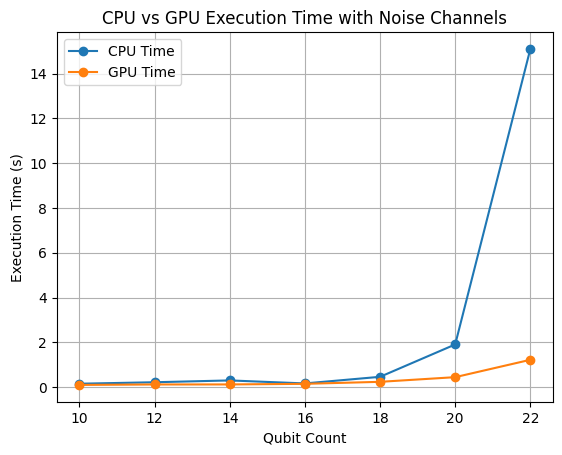

In [20]:
import matplotlib.pyplot as plt
plt.plot(range(10, 23, 2), c_t, label='CPU Time', marker='o')
plt.plot(range(10, 23, 2), g_t, label='GPU Time', marker='o')
plt.xlabel('Qubit Count')
plt.ylabel('Execution Time (s)')
plt.title('CPU vs GPU Execution Time with Noise Channels')
plt.legend()
plt.grid()
plt.show()